In [1]:
# TODO: handle rgb or bw images
# TODO: slice edges and get median of the rows to find ridges
# TODO see how uri calculated the ridges

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
from scipy import ndimage

In [2]:

def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val

def calc_min_max_coordinates(image, crop_val=50):
    temp = thresholded(image, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def crop_full_scan(image):
    temp = crop(image, 600, 4300, 1000, 6000)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates(temp)
    temp = crop(image, 600+ymin, 600+ymax, 1000+xmin, 1000+xmax)
    return temp

def crop_thresholded(image):
    temp = crop(image, 0, image.shape[0]-1, 0, image.shape[1]-1)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates(temp)
    temp = crop(image, ymin, ymax, xmin, xmax)
    return temp

# TODO: fix performance!!! http://scikit-image.org/docs/dev/user_guide/tutorial_parallelization.html
def combine_3_images_to_RGB(red, green, blue):
    new_image = np.empty((blue.shape[0],blue.shape[1],3))
    for x in range(0, blue.shape[0]):
        for y in range(0, blue.shape[1]):
            new_image[x,y,0] = red[x,y]
            new_image[x,y,1] = green[x,y]
            new_image[x,y,2] = blue[x,y]
    return new_image

def slice_image_left_edge(original, width=200, rotate=0):
    rot = ndimage.rotate(original, rotate)
    # Slice the left slice of the so-called "blue" image
    left_edge_orig = crop(rot, 1, 1400, 1, width)
    left_edge_orig = crop_thresholded(left_edge_orig)

    # Copy to a new array so we don't thrash the origin
    left_edge = np.empty_like (left_edge_orig)
    np.copyto(left_edge, left_edge_orig)

    # Zero down low level "noise" values
    low_values_indices = left_edge < 30  # Where values are low
    left_edge[low_values_indices] = 0  # All low values set to 0
    return left_edge

def get_best_angle_rotation(original, crop=True, width=200):
    min_var = 99999999999
    best_angle = -10
    for x in range(-5,5):
        if crop:            
            rot_edge = slice_image_left_edge(original, width, x)
        else:
            rot_edge = ndimage.rotate(original, x)
        left_var = np.var(rot_edge, axis=1)
        # left_var = np.apply_along_axis(lambda v: np.var(v[np.nonzero(v)]), 1, rot_edge)
        var_sum = np.sum(left_var)
        if (var_sum < min_var):
            min_var = var_sum
            best_angle = x
    print ("best_angle="+str(best_angle))
    return best_angle

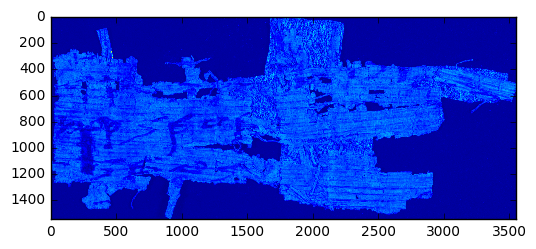

In [3]:
# Read the blue wave-length image
if "il239838" in os.getcwd():
    blue = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/P598-Fg009-R/P598-Fg009-R-C01-R01-D07012014-T124136-LR445__001.jpg")
else:
    f = urllib.request.urlopen("https://dl.dropboxusercontent.com/s/31b96942qdcn73k/P598-Fg009-R-C01-R01-D07012014-T124136-LR445__001.jpg")
    blue = img.imread(f, format='jpeg')

# Smart-crop the image to get rid of all the noise and redundant area
blue = crop_full_scan(blue)

# Show the relevant image
plt.imshow(blue)


In [4]:
blue.shape

(1546, 3549)

best_angle=4


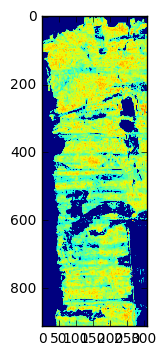

In [111]:
best_rotation = get_best_angle_rotation(blue, True, 350)
left_edge_rotated = slice_image_left_edge(blue, 350, best_rotation)
plt.imshow(left_edge_rotated)

best_angle=1


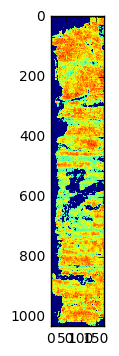

In [105]:
best_rotation = get_best_angle_rotation(blue, True, 200)
left_edge_rotated = slice_image_left_edge(blue, 200, best_rotation)
plt.imshow(left_edge_rotated)

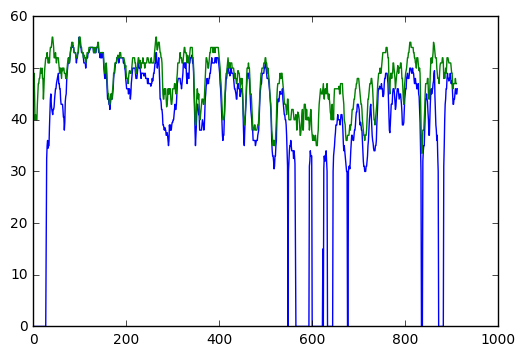

In [92]:
# Get the median for each row
left_med = np.median(left_edge_rotated, axis=1)

# Get the median while ignoring zeros
left_edge_rotated = crop_thresholded(left_edge_rotated)
adjusted_left_median = np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]), 1, left_edge_rotated)

# Draw the median graph - reflecting a kind of a ridges fingerprint
plt.plot(left_med)
plt.plot(adjusted_left_median)

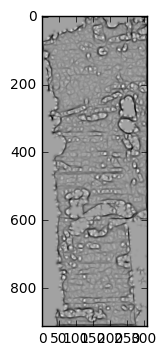

In [144]:
# This is a first attempt to run ridge filter using the major eigenvalue of the Hessian matrix
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

# the ridge filter is the major eigenvalue of the Hessian matrix
hxx, hxy, hyy = hessian_matrix(left_edge_rotated, sigma=3)
i1, i2 = hessian_matrix_eigvals(hxx, hxy, hyy)
#i2 is the major eigenvalue...

#Visualise the result
plt.imshow(i2, cmap='gray')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

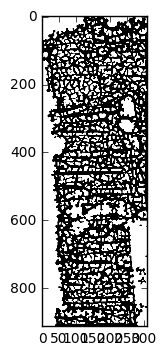

In [167]:
temp = thresholded(i2, -0.0007)
# i2[400]
# temp = thresholded(i2, 0.07)
temp = temp * 1
# temp = np.nonzero(temp)
plt.imshow(temp, cmap='gray')
temp[400]

In [157]:
i2[400]
# np.logical_and(*[i2 > 0.07  for t in enumerate([0, 0])])[400]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -2.85276403e-08,  -1.00647908e-07,  -2.63307366e-07,
        -6.28699953e-07,  -1.28473173e-06,  -2.37923876e-06,
        -3.95375900e-06,  -5.93924473e-06,  -8.05344658e-06,
        -9.77721650e-06,  -7.88789161e-06,   1.67169100e-06,
         1.60854550e-05,